In [5]:
import tifffile
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os
import bin2cell as b2c

def patched_load_image(image_path, **kwargs):
    print(f"Loading image via tifffile: {image_path}")
    img = tifffile.imread(image_path)
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[0] == 3 and img.ndim == 3:
        img = np.moveaxis(img, 0, -1)
    return img

# Loading data

In [11]:
! ls '/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_IMMUNEX012/outs/binned_outputs/square_002um'

filtered_feature_bc_matrix     raw_feature_bc_matrix	 raw_probe_bc_matrix.h5
filtered_feature_bc_matrix.h5  raw_feature_bc_matrix.h5  spatial


In [14]:
visium_path = '/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_IMMUNEX012/outs/'
tiff_path = "/home/mounim/rawdata/IMMUNEX/PJ2410310_250214/IMAGE/HE_nanozoomer_tif/IMMUNEX012_Visium_HE_x40_z0.tif"

In [15]:
binned_2um_path = visium_path + "binned_outputs/square_002um/"
source_image_path = tiff_path
spaceranger_image_path = visium_path + "spatial"

In [16]:
adata = b2c.read_visium(binned_2um_path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )
adata.var_names_make_unique()
adata


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 10715274 × 18536
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# Filters

In [17]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata


AnnData object with n_obs × n_vars = 10130743 × 18190
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

# Scaling

In [67]:
os.getcwd()

'/scratch/Projects/IMMUNEX/notebooks/6.Full Pipeline/IMMUNEX012'

In [18]:
# The b2c.scaled_he_image() function crops the image to an area around the actual spatial grid plus a default buffer of 150 pixels. The new coordinates are captured in .obsm["spatial_cropped_150_buffer"] and the new image can be used for plotting by providing basis="spatial_cropped_150_buffer" and img_key="0.5_mpp_150_buffer" to sc.pl.spatial().
buffer = 150
mpp = 0.5

try:
    b2c.scaled_he_image(adata, mpp=mpp, save_path='/scratch/Projects/IMMUNEX/notebooks/6.Full Pipeline/IMMUNEX012/' + "stardist/he.tiff", buffer = 150)
except:
    # Patching loading to adapt to file format
    b2c.bin2cell.load_image = patched_load_image
    b2c.scaled_he_image(adata, mpp=mpp, save_path='/scratch/Projects/IMMUNEX/notebooks/6.Full Pipeline/IMMUNEX012/' + "stardist/he.tiff", buffer = 150)
    # reload original function
    importlib.reload(b2c.bin2cell) 
    

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


# Destripe

In [19]:
# The function b2c.destripe() is defined to correct for this. It identifies a quantile (default is 0.99) of total counts for each row and divides the counts of the spots in that row by that value. This procedure is then repeated for the columns and stored as .obs["n_counts_adjusted"]).
b2c.destripe(adata)

_construct.py (163): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


# Align coordinates

In [20]:
import json
sf_path = binned_2um_path + 'spatial/scalefactors_json.json'
with open(sf_path) as f:
    scale = json.load(f)['tissue_hires_scalef']
    
print(f"Scale factor (pixel → spatial): {scale:.6f}")

def convert_row(pixel_y, scale):
    return int(round(scale * pixel_y))

def convert_col(pixel_x, scale):
    return int(round(scale * pixel_x))



Scale factor (pixel → spatial): 0.054003


In [21]:
bbox=(center_x - 100 ,center_y - 100,center_x + 100,center_y + 100)
array_y_min=convert_row(scale, bbox[1])
array_y_max=convert_row(scale, bbox[3])
array_x_min=convert_col(scale, bbox[0])
array_x_max=convert_col(scale, bbox[2])

print("min x:\t{} --> {}\nmax x:\t{} --> {}\nmin y:\t{}  --> {}\nmax y:\t{}  --> {}\n".format(
    bbox[0],array_x_min,bbox[2],array_x_max,bbox[1],array_y_min,bbox[3],array_y_max))


NameError: name 'center_x' is not defined

# Cropped image

In [ ]:
adata.obs['array_row']

In [ ]:
mask = ((adata.obs['array_row'] >= 1000) & 
        (adata.obs['array_row'] <= 1100) & 
        (adata.obs['array_col'] >= 1000) & 
        (adata.obs['array_col'] <= 1100)
       )

bdata = adata[mask]
print(bdata)


In [ ]:
# bdata.uns

anndata.py (1230): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1230): Trying to modify attribute `.var` of view, initializing view as actual.


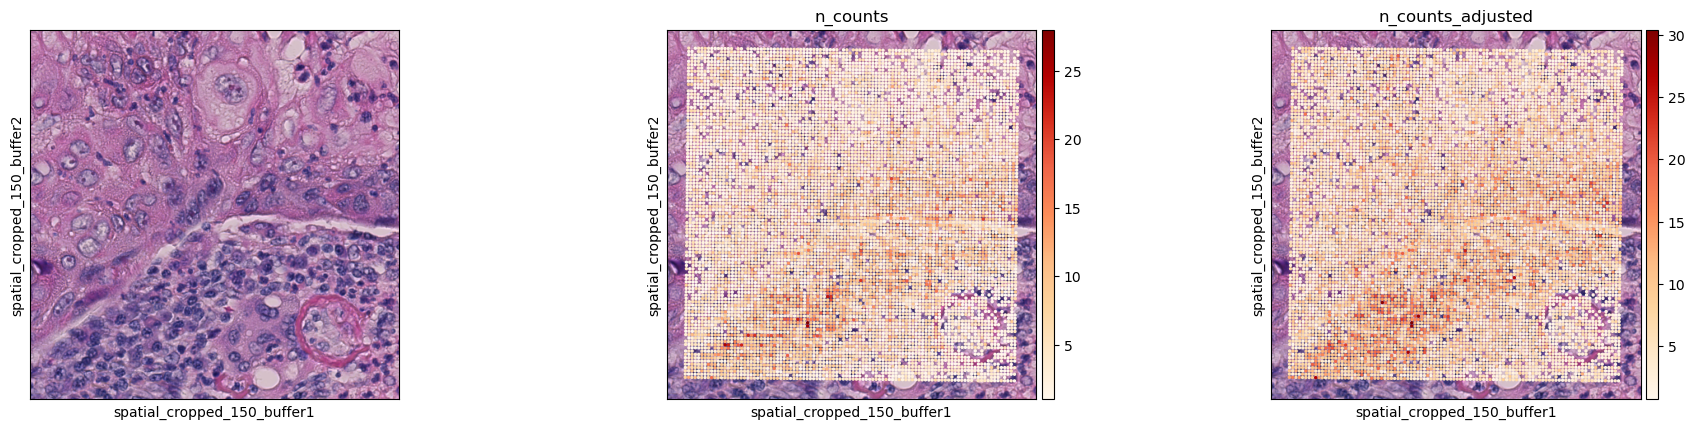

In [82]:
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
# sc.pl.spatial(adata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd", # use this one for full image. Takes long
              img_key=f"{mpp}_mpp_{buffer}_buffer", basis=f"spatial_cropped_{buffer}_buffer")


# Stardist predict

In [83]:
prob_thresh=0.01
b2c.stardist(image_path= "stardist/he.tiff", 
             labels_npz_path= "stardist/he.npz", 
             stardist_model="2D_versatile_he", 
             prob_thresh=prob_thresh
            )


Loading image via tifffile: stardist/he.tiff
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


  0%|                                                                                                                                                                                                                         | 0/16 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [2:28:39<00:00, 557.49s/it]


Found 547806 objects


load the resulting cell calls into the object. The relevant parameters are:
 - The labels generated in the previous step
 - If the segmented image was based on array (GEX visualisation of the grid) or spatial (rescaled H&E image) coordinates
 - The key that matches the image
 - The mpp value used

In [ ]:
b2c.insert_labels(adata, 
                  labels_npz_path= "stardist/he.npz", 
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )


In [ ]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer", legend_loc='none')


# Segmentation results over the H&E image.

In [ ]:
crop = b2c.get_crop(bdata, basis="spatial", spatial_key="spatial_cropped_150_buffer", mpp=mpp)

rendered = b2c.view_labels(image_path= "stardist/he.tiff", 
                           labels_npz_path="stardist/he.npz", 
                           crop=crop
                          )
plt.imshow(rendered)


# Nuclei expand

In [ ]:
b2c.expand_labels(adata, 
                  labels_key='labels_he', 
                  expanded_labels_key="labels_he_expanded"
                 )


In [ ]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he_expanded"], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")


# GEx segmentation

In [ ]:
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path= "stardist/gex.tiff")


In [ ]:
b2c.stardist(image_path= 'visium/' + "stardist/gex.tiff", 
             labels_npz_path= 'visium/' + "stardist/gex.npz", 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=0.05, 
             nms_thresh=0.5
            )


In [ ]:
b2c.insert_labels(adata, 
                  labels_npz_path='visium/'+"stardist/gex.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )


In [ ]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"], img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")


In [ ]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)

#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path= 'visium/' + "stardist/gex.tiff", 
                           labels_npz_path= 'visium/' + "stardist/gex.npz", 
                           crop=crop,
                           stardist_normalize=True
                          )
plt.imshow(rendered)


# Slavage

In [ ]:
b2c.salvage_secondary_labels(adata, 
                             primary_label="labels_he_expanded", 
                             secondary_label="labels_gex", 
                             labels_key="labels_joint"
                            )


In [ ]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source", "labels_joint"], 
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")


# Aggregation

In [ ]:
cdata = b2c.bin_to_cell(adata, labels_key="labels_joint", spatial_keys=["spatial", "spatial_cropped_150_buffer"])

cell_mask = ((cdata.obs['array_row'] >= array_y_max+120) & 
             (cdata.obs['array_row'] <= array_y_min+180) & 
             (cdata.obs['array_col'] >= array_x_min) & 
             (cdata.obs['array_col'] <= array_x_max)
            )

ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color=[None, 'Lyz1'], 
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")



# Clustering

In [ ]:
# Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(cdata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(cdata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(cdata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(cdata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(cdata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column
sc.tl.leiden(cdata, resolution=0.35, key_added="clusters")


In [ ]:
cdata.obs['clusters'].value_counts()


In [ ]:
ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color='clusters',
              img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer")
